# Probability Weight Generation Demo

This notebook walks through loading an ExaSPIM tile from S3, estimating a background model, generating the percentile-based probability weights for the profile estimation, and storing the result back to OME-Zarr. It finishes with a few simple visualizations to help tune the weighting parameters.

In [ ]:
%matplotlib inline

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import s3fs
import zarr
import os

from exaspim_flatfield_correction.background import estimate_bkg
from exaspim_flatfield_correction.fitting import calc_percentile_weight
from exaspim_flatfield_correction.utils.zarr_utils import store_ome_zarr, initialize_zarr_group, parse_ome_zarr_transformations

In [2]:
# --- User parameters ---------------------------------------------------------
AWS_REGION = "us-west-2"
S3_TILE_PATH = "s3://aind-open-data/exaSPIM_784802_2025-09-10_17-08-56/SPIM.ome.zarr/tile_000019_ch_488.zarr"
TILE_RESOLUTION = "0"  # OME-NGFF path within the tile to read
OUTPUT_WEIGHT_ZARR = "s3://aind-msma-morphology-data/cameron.arshadi/flatfield-weights-test.zarr"
OVERWRITE_OUTPUT = True

In [3]:
# Connect to S3 and open the tile as a Dask array
s3 = s3fs.S3FileSystem(anon=False, client_kwargs={"region_name": AWS_REGION})
tile_store = s3fs.S3Map(root=S3_TILE_PATH, s3=s3, check=False)

tile_group = zarr.open_group(tile_store, mode="r")
if TILE_RESOLUTION not in tile_group:
    raise KeyError(f"Resolution {TILE_RESOLUTION!r} not found in {S3_TILE_PATH}")

transforms = parse_ome_zarr_transformations(tile_group, TILE_RESOLUTION)

# Load the requested resolution into memory for background estimation
# (adjust if the volume is very large)
tile_dask = da.from_zarr(tile_group[TILE_RESOLUTION]).squeeze().astype(np.float32)
print(f"Loaded tile with shape {tile_dask.shape} and chunks {tile_dask.chunksize}")

tile_np = tile_dask.compute()


Loaded tile with shape (2304, 1330, 1774) and chunks (128, 256, 256)


In [4]:
# Estimate the background slices and subtract them from the tile
background_2d, retained_indices = estimate_bkg(tile_np)
print(f"Retained {len(retained_indices)} background slices")

corrected_da = da.clip(tile_dask - background_2d, 0, None)

Retained 116 background slices


In [5]:
LOW_PERCENTILE = 50.0
HIGH_PERCENTILE = 99.99
LOGISTIC_EPS = 0.0001
SMOOTH_SIGMA = 1.0
START_FRAC = 0.8  # fraction along the percentile span where the ramp begins
NU = 2  # nu=1 matches logistic; larger values skew toward the high percentile

In [6]:

# Build the percentile-based probability weights
bg_reference = corrected_da[retained_indices].compute()
weights_da = calc_percentile_weight(
    corrected_da,
    bg_reference,
    low_percentile=LOW_PERCENTILE,
    high_percentile=HIGH_PERCENTILE,
    eps=LOGISTIC_EPS,
    smooth_sigma=SMOOTH_SIGMA,
    start_frac=START_FRAC,
    nu=NU,
)

# Persist locally to reuse the computed result for plotting and export
weights_np = weights_da.compute()


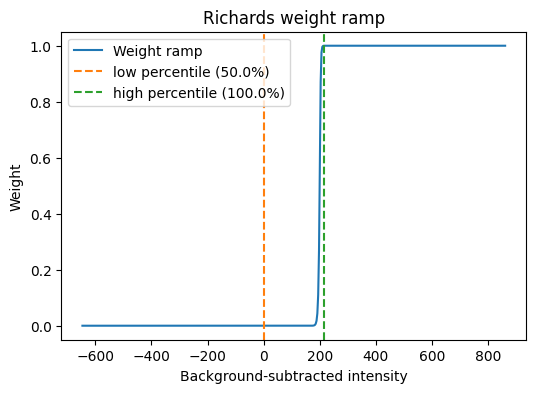

<Figure size 640x480 with 0 Axes>

In [7]:
# Plot the Richards ramp used for weighting
percentiles = np.percentile(bg_reference, [LOW_PERCENTILE, HIGH_PERCENTILE])
p_low, p_high = [float(v) for v in percentiles]

if p_high < p_low:
    p_low, p_high = p_high, p_low

delta_raw = p_high - p_low
span = max(delta_raw, 1e-6)
x_vals = np.linspace(p_low - 3 * span, p_high + 3 * span, 512)

if delta_raw <= 0:
    ramp = np.where(x_vals > p_low, 1.0, 0.0)
else:
    t_vals = np.clip((x_vals - p_low) / delta_raw, 0.0, 1.0)
    y1 = LOGISTIC_EPS
    y2 = 1.0 - LOGISTIC_EPS
    A_s = y1 ** (-NU) - 1.0
    A_h = y2 ** (-NU) - 1.0
    denom = max(1e-8, 1.0 - START_FRAC)
    B = np.log(A_s / A_h) / (1.0 - START_FRAC)
    Q = A_h * np.exp(B)
    z_vals = -B * t_vals
    ramp = (1.0 / (1.0 + Q * np.exp(z_vals))) ** (1.0 / NU)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x_vals, ramp, label="Weight ramp")
ax.axvline(p_low, color="tab:orange", linestyle="--", label=f"low percentile ({LOW_PERCENTILE:.1f}%)")
ax.axvline(p_high, color="tab:green", linestyle="--", label=f"high percentile ({HIGH_PERCENTILE:.1f}%)")
ax.set_xlabel("Background-subtracted intensity")
ax.set_ylabel("Weight")
ax.set_title("Richards weight ramp")
ax.legend()
plt.show()
plt.savefig("weight_ramp.png", dpi=150)


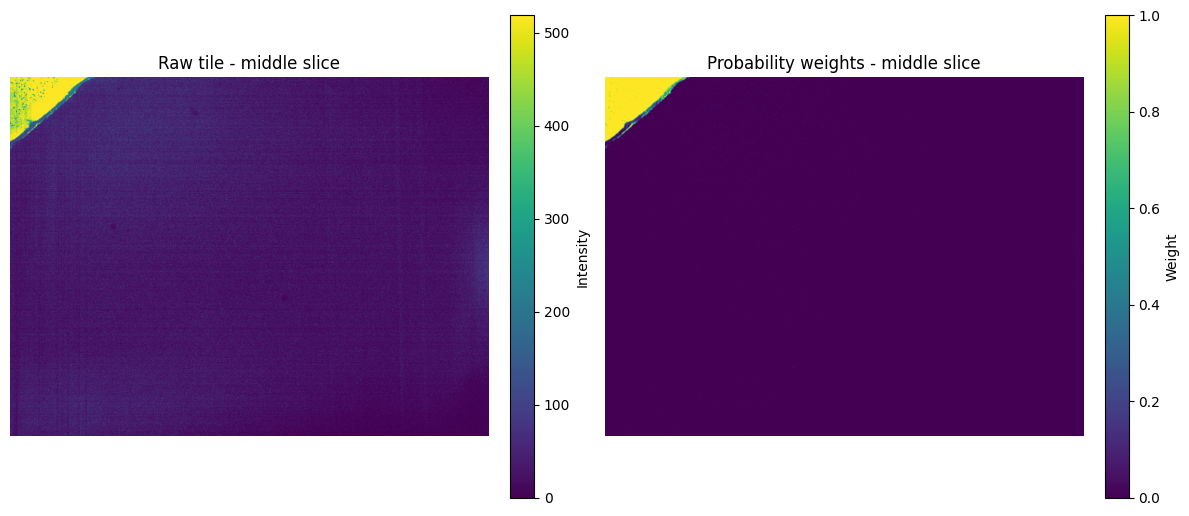

<Figure size 640x480 with 0 Axes>

In [8]:
# Visualize the middle slice of the raw data and the weight volume side by side
mid_idx = weights_np.shape[0] // 2

raw_mid_slice = corrected_da[mid_idx].compute()
weights_mid_slice = weights_np[mid_idx]

# Stretch the raw slice contrast for display to avoid saturation
raw_vmin, raw_vmax = np.percentile(raw_mid_slice, (0, 99))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
raw_img = axes[0].imshow(raw_mid_slice, cmap="viridis", vmin=raw_vmin, vmax=raw_vmax)
axes[0].set_title("Raw tile - middle slice")
axes[0].axis("off")
fig.colorbar(raw_img, ax=axes[0], fraction=0.046, pad=0.04, label="Intensity")

weight_img = axes[1].imshow(weights_mid_slice, cmap="viridis", vmin=0.0, vmax=1.0)
axes[1].set_title("Probability weights - middle slice")
axes[1].axis("off")
fig.colorbar(weight_img, ax=axes[1], fraction=0.046, pad=0.04, label="Weight")

plt.tight_layout()
plt.show()
plt.savefig("weight_middle_slice_comparison.png", dpi=150)


In [9]:
# Store the weight volume as an OME-Zarr on S3
root_group = initialize_zarr_group(
    OUTPUT_WEIGHT_ZARR,
    mode="w" if OVERWRITE_OUTPUT else "w-",
    aws_region=AWS_REGION,
)

store_ome_zarr(
    weights_da,
    OUTPUT_WEIGHT_ZARR,
    n_levels=4,
    voxel_size=transforms["scale"][-3:],
    origin=transforms["translation"],
    overwrite=OVERWRITE_OUTPUT,
    aws_region=AWS_REGION,
    write_empty_chunks=False,
)

print(f"Stored weights to {OUTPUT_WEIGHT_ZARR}")


Stored weights to s3://aind-msma-morphology-data/cameron.arshadi/flatfield-weights-test.zarr
